In [1]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
import graphviz

from IPython.display import Image

%matplotlib inline

# Load Data

In [2]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [3]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

# Decision Tree Class

In [4]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of binary labels shape = (n, 1)
    :return entropy: entropy value
    '''
    # count the different labels and their counts in the label array
    label_val, label_count = np.unique(label_array, return_counts= True)
    tot_count = np.sum(label_count)
    label_prob = label_count / tot_count
    epsilon = 1e-12
    entropy = -(label_prob * np.log(label_prob + epsilon)).sum()
    return entropy

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    label_val, label_count = np.unique(label_array, return_counts= True)
    tot_count = np.sum(label_count)
    label_prob = label_count / tot_count
    gini = (np.sum(label_prob * (1 - label_prob)))
    return gini 

In [5]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method with args (X, y) returning loss
        :param leaf_value_estimator: method for estimating leaf value from array of ys
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.is_leaf = False
        '''
        ----EDIT: adding additional parameters to the decision tree class----
        '''
        self.left = None
        self.right = None
        self.split_id = -1
        self.split_value = None
        self.value = None

    def fit(self, x, y):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recurisive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        # first check if the current node is to be a leaf or has to be split further
        if((self.depth >= self.max_depth) or (x.shape[0] < self.min_sample)):
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self

        # in case the node needs to be split - we need to create the subsets of data that need to be given to each child node
        self.find_best_feature_split(x, y)
        
        if self.split_id == -1:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        
        left_idx = np.where(x[:, self.split_id] <= self.split_value)
        right_idx = np.where(x[:, self.split_id] > self.split_value)
        
        if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
            self.split_id = -1
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        
        # create the left and right subtrees
        self.left = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, self.depth + 1, self.min_sample, self.max_depth)
        self.right = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, self.depth + 1, self.min_sample, self.max_depth)
        
        self.left.fit(x[left_idx], y[left_idx])
        self.right.fit(x[right_idx], y[right_idx])
        
        return self
    
    def find_best_split(self, x_node, y_node, feature_id):
        '''
        For feature number feature_id, returns the optimal splitting point 
        for data X_node, y_node, and corresponding loss.
    
        :param x_node: a numpy array of training data, shape = (n_node, m)
        :param y_node: a numpy array of labels, shape = (n_node, 1)
        '''
        min_loss = np.inf
        split_value = np.inf
        
        x_node_ftr = x_node[:, feature_id]  # Extract the feature column
        num_samples = len(y_node)
        
        # Sort the input feature and maintain corresponding labels
        sort_idx = np.argsort(x_node_ftr)
        sorted_x_node_ftr = x_node_ftr[sort_idx]
        sorted_y_node = y_node[sort_idx]
        
        # Identify unique values in the sorted feature column
        unique_values = np.unique(sorted_x_node_ftr)
        
        for value in unique_values:
            # Split the data based on the unique value
            l_idx_mask = sorted_x_node_ftr <= value
            r_idx_mask = ~l_idx_mask  # Complement of the left mask
            
            y_left = sorted_y_node[l_idx_mask]
            y_right = sorted_y_node[r_idx_mask]
            
            # Skip if either side is empty
            if len(y_left) == 0 or len(y_right) == 0:
                continue
            
            # Compute loss
            net_loss = (
                (len(y_left) / num_samples) * self.split_loss_function(y_left) +
                (len(y_right) / num_samples) * self.split_loss_function(y_right)
            )
            
            # Update if current loss is better
            if net_loss < min_loss:
                min_loss = net_loss
                split_value = value
        
        return split_value, min_loss


        

    def find_best_feature_split(self, x_node, y_node):
        '''
        Returns the optimal feature to split and best splitting point 
        for data X_node, y_node.
        
        ----EDIT: I have edited the shape of param X to (n_node, m) (prvsly mentioned as (n_node))----
        :param X: a numpy array of training data, shape = (n_node, m)
        
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        min_loss = np.inf
        for i in range(x_node.shape[1]):
            # print(f"find best feature split - feature: {i}")
            curr_feature = i
            curr_feature_min_split_val, curr_feature_min_loss = self.find_best_split(x_node, y_node, feature_id= curr_feature)
            if(min_loss > curr_feature_min_loss):
                self.split_id = curr_feature # curr best feature found
                self.split_value = curr_feature_min_split_val # current value of best feature on which the split loss is minimum
                min_loss = curr_feature_min_loss
        

    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

# Decision Tree Classifier

In [6]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [7]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }


    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Decision Tree Boundary

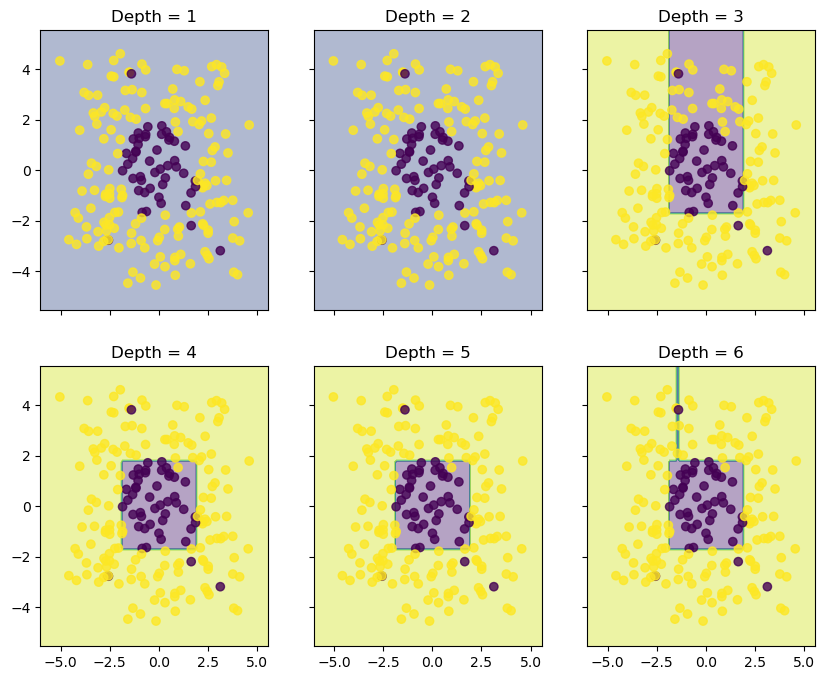

In [8]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1, min_sample=2)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2, min_sample=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3, min_sample=2)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4, min_sample=2)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5, min_sample=2)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6, min_sample=2)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label[:,0], alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Compare decision tree with tree model in sklearn

In [9]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=5)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

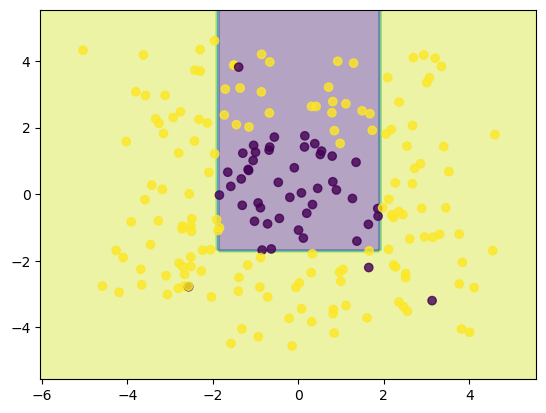

In [10]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = np.array([clf.predict(x[np.newaxis,:]) for x in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(x_train[:, 0], x_train[:, 1], 
c=y_train_label[:,0], alpha=0.8)

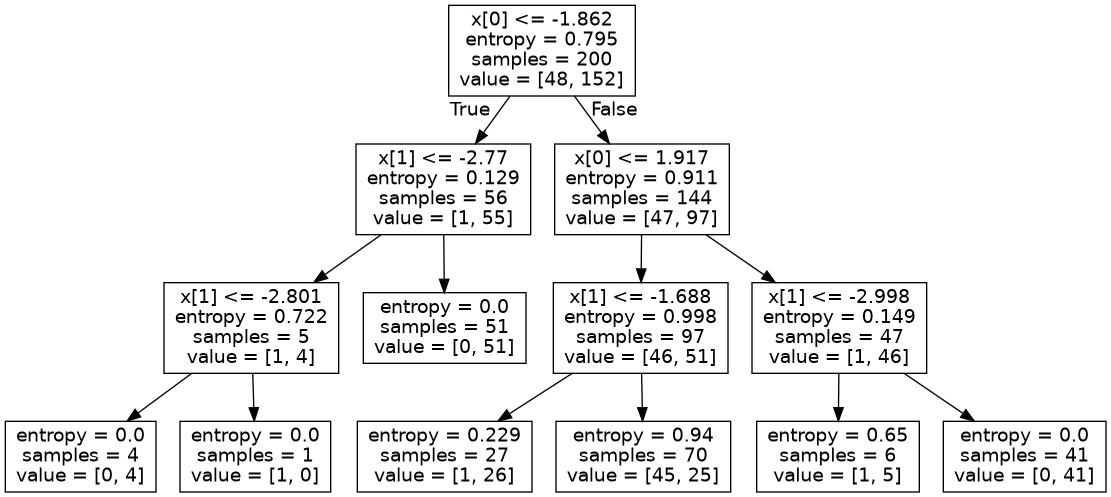

In [11]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png
Image(filename='tree_classifier.png')

# Decision Tree Regressor

In [12]:
# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    median = np.median(y)
    mae = np.mean(np.abs(y - median))
   
    return mae

In [13]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Fit regression tree to one-dimensional regression data

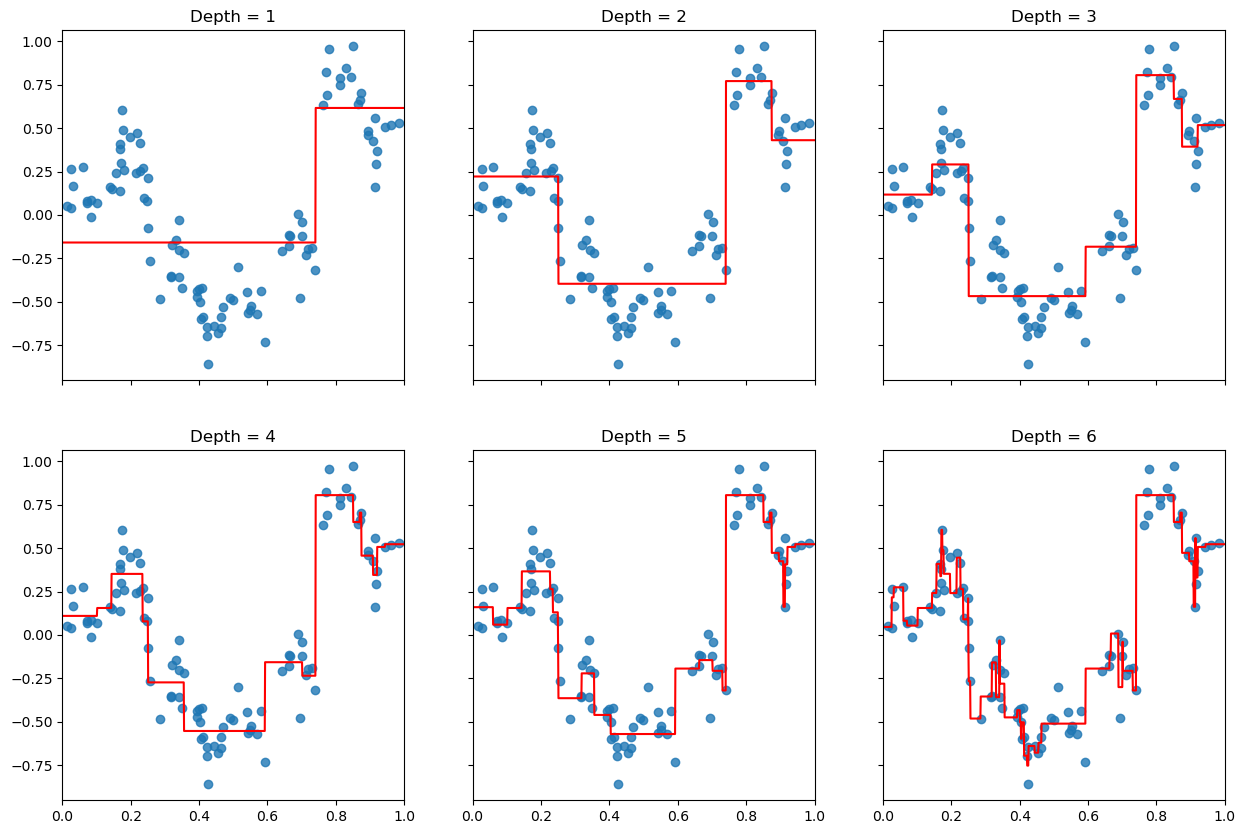

In [14]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=3, loss_function='mae', estimator='mean')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=3, loss_function='mae', estimator='mean')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=3, loss_function='mae', estimator='mean')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=3, loss_function='mae', estimator='mean')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=3, loss_function='mae', estimator='mean')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=10,  min_sample=3, loss_function='mae', estimator='mean')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

# Compare with scikit-learn

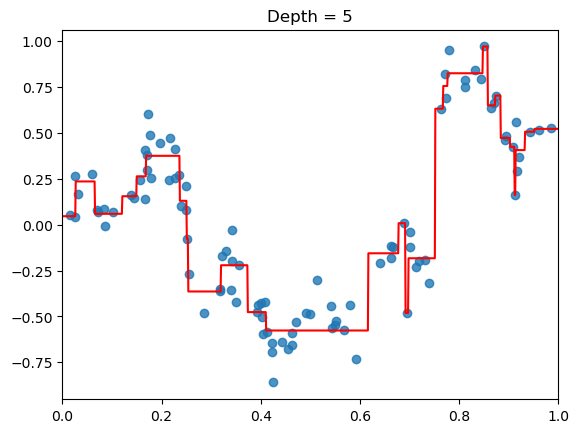

In [15]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)
max_depth = 5

clf = DecisionTreeRegressor(criterion='friedman_mse', max_depth=max_depth, min_samples_split=3)
clf.fit(x_krr_train, y_krr_train)
export_graphviz(clf, out_file='tree_classifier.dot')

y_range_predict = np.array([clf.predict(x[np.newaxis,:]) for x in x_range]).reshape(-1, 1)
  
plt.plot(x_range, y_range_predict, color='r')
plt.scatter(x_krr_train, y_krr_train, alpha=0.8)
plt.title('Depth = {}'.format(max_depth))
plt.xlim(0, 1)
plt.show()

# Gradient Boosting Method

In [16]:

#Pseudo-residual function.

def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

In [17]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.01, 
                 min_sample=5, max_depth=5):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual between training labels and predicted labels at each iteration
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth

        self.estimators = [] #will collect the n_estimator models
    
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        :train_data array of inputs of size (n_samples, m_features) 
        :train_target array of outputs of size (n_samples,) 
        '''
        self.base_model = DecisionTreeRegressor(criterion= 'squared_error', max_depth= self.max_depth, min_samples_leaf= self.min_sample)
        self.base_model.fit(train_data, train_target)
        
        for i in range(self.n_estimator):
            pred = self.learning_rate * self.base_model.predict(train_data)
            for model in self.estimators:
                pred = pred + self.learning_rate * model.predict(train_data)
                
            residual = self.pseudo_residual_func(train_target, pred)
            
            h_m = DecisionTreeRegressor(max_depth= self.max_depth, min_samples_leaf= self.min_sample)
            h_m.fit(train_data, residual)
            self.estimators.append(h_m)
        
        
    def predict(self, test_data):
        '''
        Predict value
        :train_data array of inputs of size (n_samples, m_features)
        '''
        
        pred = self.base_model.predict(test_data)
        for model in self.estimators:
            pred = pred + (self.learning_rate * model.predict(test_data))
        return pred

# 1-D GBM visualization - KRR data

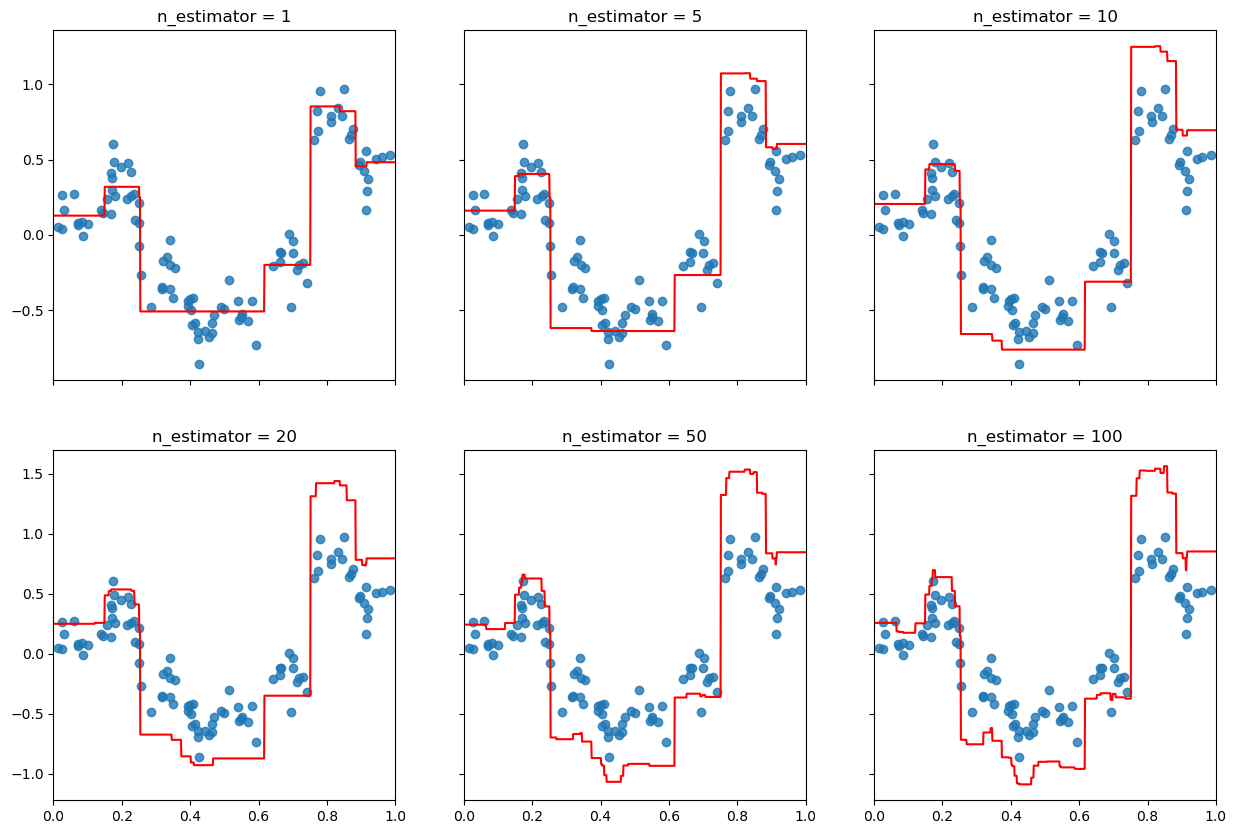

In [18]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, 
                               max_depth=3, learning_rate=0.1)  
    gbm_1d.fit(x_krr_train, y_krr_train[:,0])
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

# Using Regression_Tree class to build the h_m models

In [19]:
class gradient_boosting_v2():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.01, 
                 min_sample=5, max_depth=5):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual between training labels and predicted labels at each iteration
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth

        self.estimators = [] #will collect the n_estimator models
    
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        :train_data array of inputs of size (n_samples, m_features) 
        :train_target array of outputs of size (n_samples,) 
        '''
        self.base_model = Regression_Tree(max_depth= self.max_depth, min_sample= self.min_sample)
        self.base_model.fit(train_data, train_target)
        
        for i in range(self.n_estimator):
            pred = self.learning_rate * np.array([self.base_model.predict_instance(instance) for instance in train_data])
            for model in self.estimators:
                pred = pred + self.learning_rate * np.array([model.predict_instance(instance) for instance in train_data])
                
            residual = self.pseudo_residual_func(train_target, pred)
            
            # h_m = DecisionTreeRegressor(max_depth= self.max_depth, min_samples_leaf= self.min_sample)
            h_m = Regression_Tree(min_sample= self.min_sample, max_depth= self.max_depth)
            h_m.fit(train_data, residual)
            self.estimators.append(h_m)
        
        
    def predict(self, test_data):
        '''
        Predict value
        :train_data array of inputs of size (n_samples, m_features)
        '''
        
        pred = np.array([self.base_model.predict_instance(instance) for instance in test_data])
        for model in self.estimators:
            pred = pred + (self.learning_rate * np.array([model.predict_instance(instance) for instance in test_data]))
        return pred

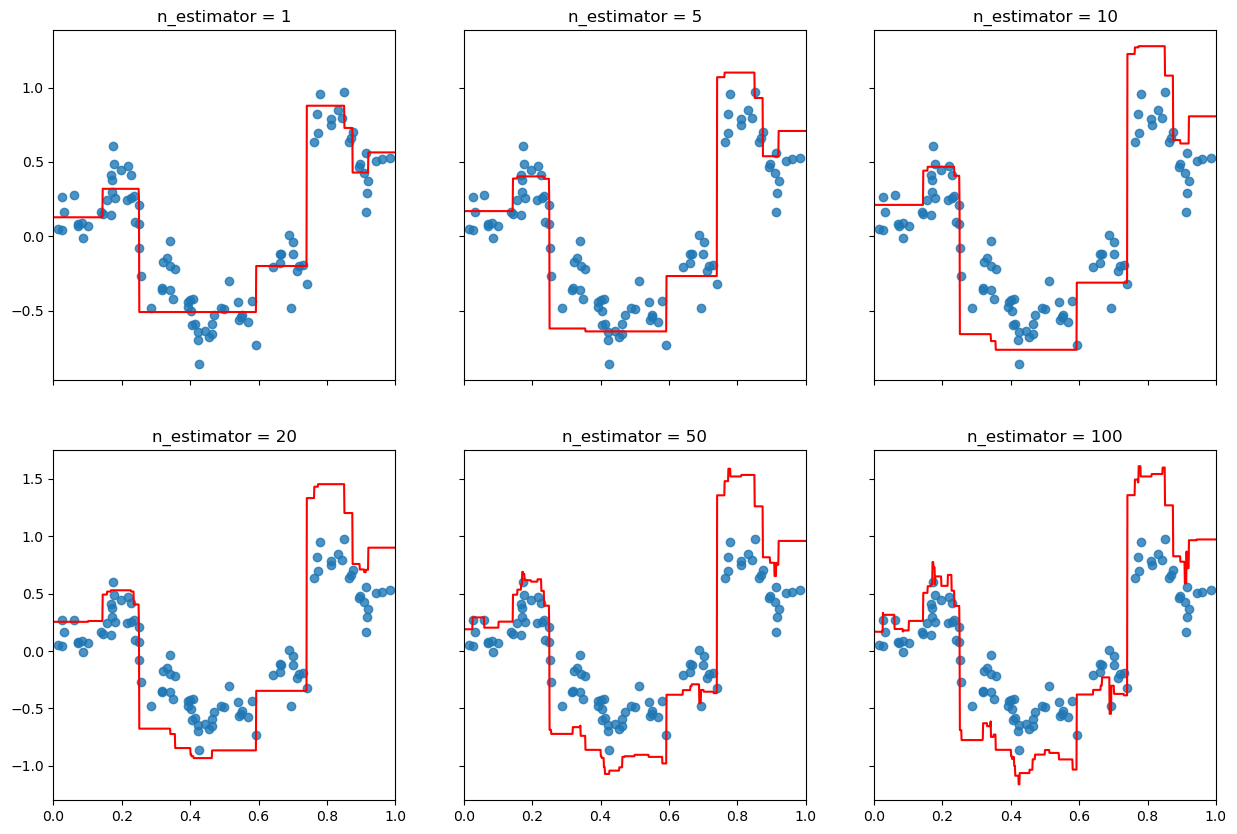

In [20]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting_v2(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, 
                               max_depth=3, learning_rate=0.1)  
    gbm_1d.fit(x_krr_train, y_krr_train[:,0])
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

# Gradient Boosting using sklearn

/home/arjun-prasad/anaconda3/envs/deep_learning/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


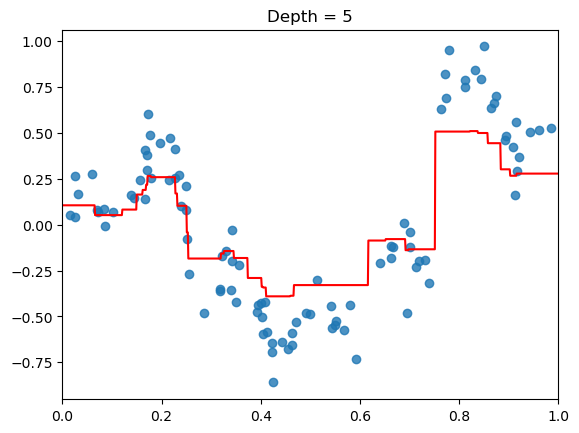

In [21]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)
max_depth = 5

clf = GradientBoostingRegressor(criterion='squared_error', max_depth=max_depth, min_samples_leaf=5, learning_rate= 0.01, n_estimators= 100)
clf.fit(x_krr_train, y_krr_train)
y_range_predict = np.array([clf.predict(x[np.newaxis,:]) for x in x_range]).reshape(-1, 1)
  
plt.plot(x_range, y_range_predict, color='r')
plt.scatter(x_krr_train, y_krr_train, alpha=0.8)
plt.title('Depth = {}'.format(max_depth))
plt.xlim(0, 1)
plt.show()